In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
# from small_script.myFunctions import *
sys.path.insert(0, "/Users/weilu/openmmawsem")
from helperFunctions.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [3]:
pd.read_excel("/Users/weilu/Research/server/nov_2019/benchmark/OpenAWSEM_benchmark_nov17.xlsx", sheet_name=0)

,PDB id,Name,Length,Has crystal,With DNA,Membrane protein
0,5m2o,T0921+0922,149+96,Yes,No,No
1,NaN,p53,393*4+200,No,Yes,No
2,6n7n,helicase,286*6,Yes,No,No
3,NaN,helicase_monomer,286+20,Yes,Yes,No
4,2IS1,uvrd,680+20,Yes,Yes,No
5,6q64,T1005,364,Yes,No,No
6,6g57,T0970,124,Yes,No,No
7,6btc,T0958,96,Yes,No,No
8,NaN,PEX,338,No,No,No
9,5e1j,tpc,741,Yes,No,Yes


In [4]:
# d = pd.read_excel("/Users/weilu/Research/server/nov_2019/benchmark/lammps.xlsx", sheet_name=1)
d = pd.read_excel("/Users/weilu/Research/server/nov_2019/benchmark/OpenAWSEM_benchmark_nov17.xlsx", sheet_name=1)

In [5]:
d.columns

Index(['PDB id', 'Length', 'Temperature', 'Terms', 'Step', 'Time1', 'Time2',
       'Time3', 'Time4', 'Time5', 'Average', 'Average/million'],
      dtype='object')

In [6]:
d

,PDB id,Length,Temperature,Terms,Step,Time1,Time2,Time3,Time4,Time5,Average,Average/million
0,1tt8,164,600-200,Full,4million,42897.5,43047.2,42734.0,43339.8,41889.7,42781.64,10695.410000
1,2is1,649,300-300,no HO/ER,0.7million,54957.1,56557.8,56992.2,57329.7,56442.1,56455.78,80651.114286
2,6btc,96,600-200,Full,4million,14684.9,14808.7,15070.9,15022.1,15150.6,14947.44,3736.860000
3,6g57,124,600-200,Full,4million,21796.2,22610.3,21928.4,21844.2,23700.0,22375.82,5593.955000
4,6n7n,1716,300-300,no HO/ER,0.05million,37900.4,36062.1,36229.0,38737.2,37949.8,37375.70,747514.000000
5,6q64,364,600-200,Full,1.5million,51876.3,51352.0,49662.0,49238.0,49444.0,50314.46,33542.973333
6,fmt,442,300-300,no HO/ER,1million,53215.2,53139.2,53459.8,53499.0,53106.0,53283.84,53283.840000
7,pex,173,600-200,Full,4million,51844.9,51696.5,49944.8,51317.8,50940.9,51148.98,12787.245000
8,sos,218,600-200,Full,4million,85632.0,83831.3,80723.9,80603.1,83117.5,82781.56,20695.390000
9,unk2,210,600-200,no HO,4million,53988.5,56105.9,55513.6,54500.1,55914.3,55204.48,13801.120000


In [7]:
d2 = d.melt(id_vars=['PDB id', 'Length', 'Temperature', 'Terms', 'Step', 'Average/million'], var_name="Run", value_name="Time")

In [8]:
d2["Step_in_millions"] = d2.Step.str.replace("million", "").apply(eval)

In [9]:
d2["Average"] = d2["Time"]/d2["Step_in_millions"]
d2 = d2.sort_values("Length").reset_index(drop=True)

In [10]:
d2 = d2.rename(columns={"PDB id":"Name", "Average":"time"})

In [11]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "fmt", "6n7n", "2is1", "6jdq", "5uak"]
pre = "/Users/weilu/Research/server/nov_2019/benchmark/20191025_benchmark"
info = []
for pdb in pdb_list:
    for i in range(5):
        fileLocation = f"run2/{pdb}/{i}/time.dat"
        try:
            t = float(np.loadtxt(f"{pre}/{fileLocation}"))
            info.append([pdb, i, t])
        except:
            print("skip ", fileLocation)
info = pd.DataFrame(info, columns=["Name", "Run", "time"])

In [12]:
pdb_length = {}
for pdb, length in zip(d["PDB id"], d["Length"]):
    pdb_length[pdb] = length
pdb_length["pex22"] = pdb_length["pex"]
info["Length"] = info["Name"].apply(lambda x: pdb_length[x])

In [13]:
data = pd.concat([d2.assign(Scheme="LAMMPS"), info.assign(Scheme="openMM")], sort=False).reset_index(drop=True)
data = data.sort_values("Length").reset_index(drop=True)

In [14]:
plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [16]:
data.to_pickle("/Users/weilu/Research/data/openAWSEM_benchmark.pkl")

In [17]:
data = pd.read_pickle("/Users/weilu/Research/data/openAWSEM_benchmark.pkl")

In [18]:
from sklearn.linear_model import LinearRegression
y = d2.time.values
X = d2.Length.values
coefs = np.polynomial.polynomial.polyfit(X, y, 2)
ffit = np.polynomial.polynomial.Polynomial(coefs)

In [19]:
info = info.sort_values("Length").reset_index(drop=True)
from sklearn.linear_model import LinearRegression
y_openMM = info.time.values
X_openMM = info.Length.values
coefs_openMM = np.polynomial.polynomial.polyfit(X_openMM, y_openMM, 2)
ffit_openMM = np.polynomial.polynomial.Polynomial(coefs_openMM)

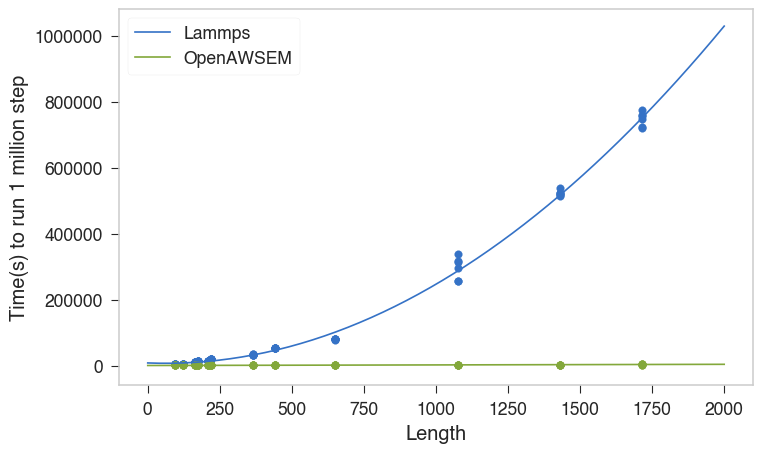

In [21]:
x = np.linspace(0, 2000)
plt.scatter(X, y)
plt.plot(x, ffit(x))
plt.plot(x, ffit_openMM(x))
plt.scatter(X_openMM, y_openMM)
# plt.plot(x, 10*x)
# plt.yscale("log")
plt.xlabel("Length")
plt.ylabel("Time(s) to run 1 million step")
plt.legend(["Lammps", "OpenAWSEM"])
plt.tight_layout()
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/benchmark.png", dpi=300)

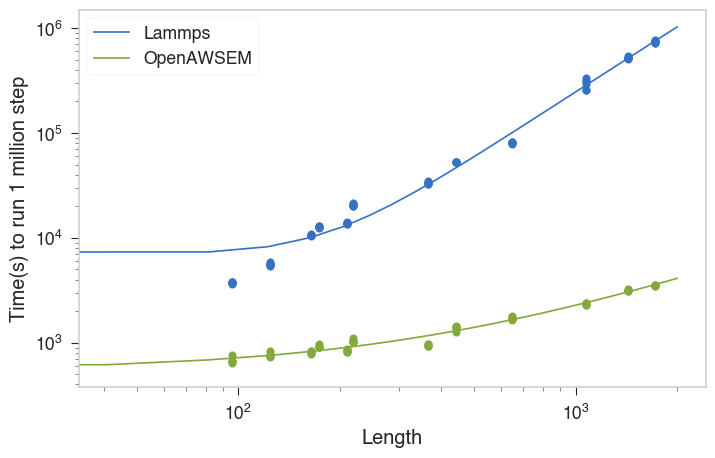

In [74]:
x = np.linspace(0, 2000)
plt.scatter(X, y)
plt.plot(x, ffit(x))
plt.plot(x, ffit_openMM(x))
plt.scatter(X_openMM, y_openMM)
# plt.plot(x, 10*x)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Length")
plt.ylabel("Time(s) to run 1 million step")
plt.legend(["Lammps", "OpenAWSEM"])
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/benchmark_logscale.png", dpi=300)

In [ ]:
from sklearn.linear_model import LinearRegression
y = d2.time.values
X = d2.Length.values
coefs = np.polynomial.polynomial.polyfit(X, y, 2)

In [ ]:
# ffit = np.polynomial.polynomial.polyval(X, coefs)
ffit = np.polynomial.polynomial.Polynomial(coefs)

In [297]:
import configparser
config = configparser.ConfigParser()
config.read("/Users/weilu/Research/server/nov_2019/phosphorylation/phosphorylation.dat")
phosphorylated_residue_index = eval(config['phosphorylation']['phosphorylated_residue_index'])
phosphorylated_residue_seq = eval(config['phosphorylation']['phosphorylated_residue_seq'])
m = eval(config['phosphorylation']['m'])

['/Users/weilu/Research/server/nov_2019/phosphorylation/phosphorylation.dat']

In [302]:
a= [1,23,4,5]

In [307]:
a.index(1)

0

In [247]:
x = np.linspace(0, 2000)

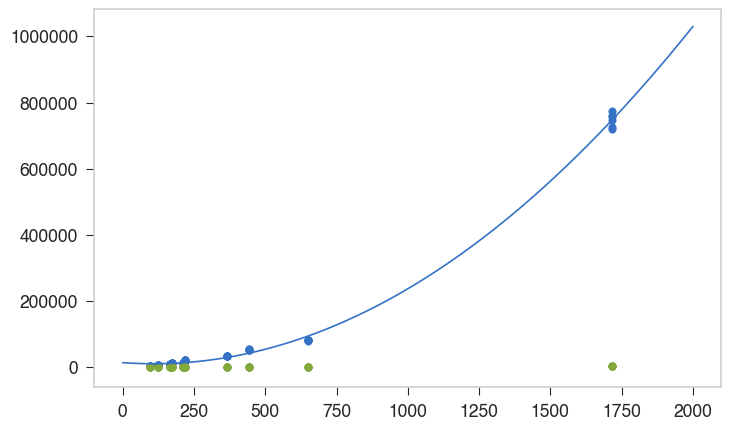

In [280]:
plt.scatter(X, y)
plt.plot(x, ffit(x))
plt.scatter(X_openMM, y_openMM)
# plt.yscale("log")

In [255]:
info = info.sort_values("Length").reset_index(drop=True)
from sklearn.linear_model import LinearRegression
y_openMM = info.time.values
X_openMM = info.Length.values
coefs_openMM = np.polynomial.polynomial.polyfit(X_openMM, y_openMM, 2)
ffit_openMM = np.polynomial.polynomial.Polynomial(coefs_openMM)

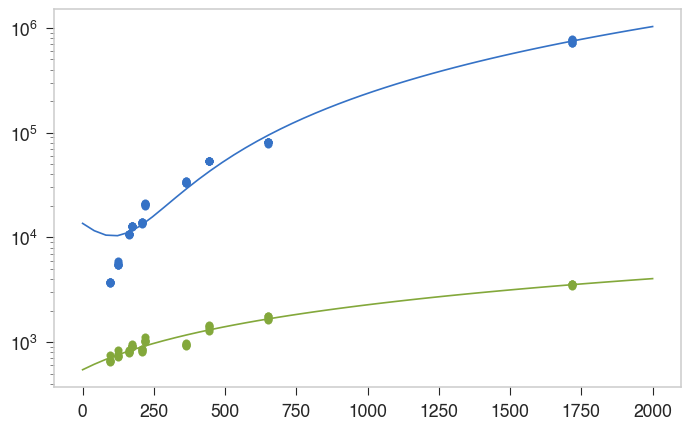

In [258]:
plt.scatter(X, y)
plt.plot(x, ffit(x))
plt.plot(x, ffit_openMM(x))
plt.scatter(X_openMM, y_openMM)
plt.yscale("log")

In [259]:
coefs_openMM

array([5.45464252e+02, 1.71001872e+00, 1.86160444e-05])

In [260]:
coefs

array([ 1.36066076e+04, -6.11588394e+01,  2.84582580e-01])

In [214]:
print(f"y = {reg.coef_[0]:.2}*x + {reg.intercept_:.2f}")

AttributeError: 'numpy.ndarray' object has no attribute 'coef_'

In [ ]:
from sklearn.linear_model import LinearRegression
timeData["Time (min)"] = timeData.time / 60
X = timeData.Length.values.reshape(-1, 1)
y = timeData["Time (min)"].values
reg = LinearRegression().fit(X, y)

sns.regplot("Length", "Time (min)", data=timeData, ci=0)
# sns.lmplot("Length", "Time (min)", data=timeData, ci=0, hue="CUDA")
sns.scatterplot("Length", "Time (min)", data=timeData, ci=0, hue="Platform")
plt.title(f"y = {reg.coef_[0]:.2}*x + {reg.intercept_:.2f}")

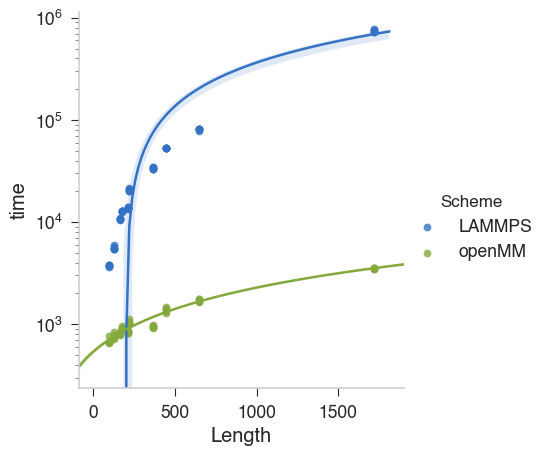

In [187]:
sns.lmplot("Length", "time", hue="Scheme", data=data)
plt.yscale("log")

In [189]:
plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

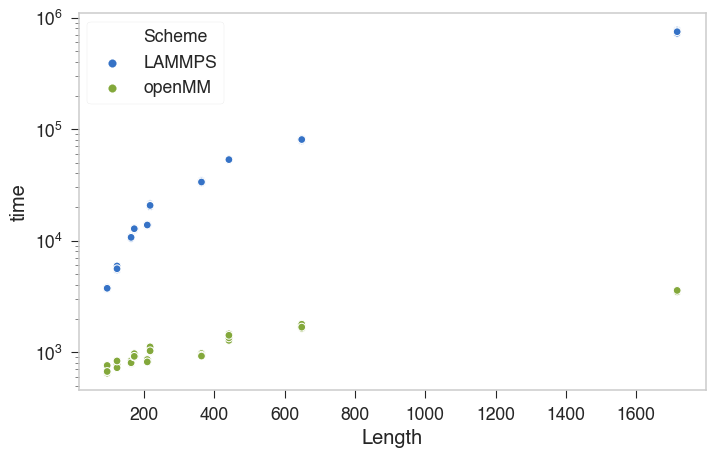

In [199]:
sns.scatterplot("Length", "time", hue="Scheme", data=data, y_jitter=True)
plt.yscale("log")

In [ ]:
sns.scatterplot("Length", "time", hue="Scheme", data=data, y_jitter=True)
plt.yscale("log")

In [197]:
data.to_csv("/Users/weilu/Research/server/nov_2019/benchmark/data.csv")

In [169]:
d2 = d2.rename(columns={"PDB id":"Name", "Average":"time"})

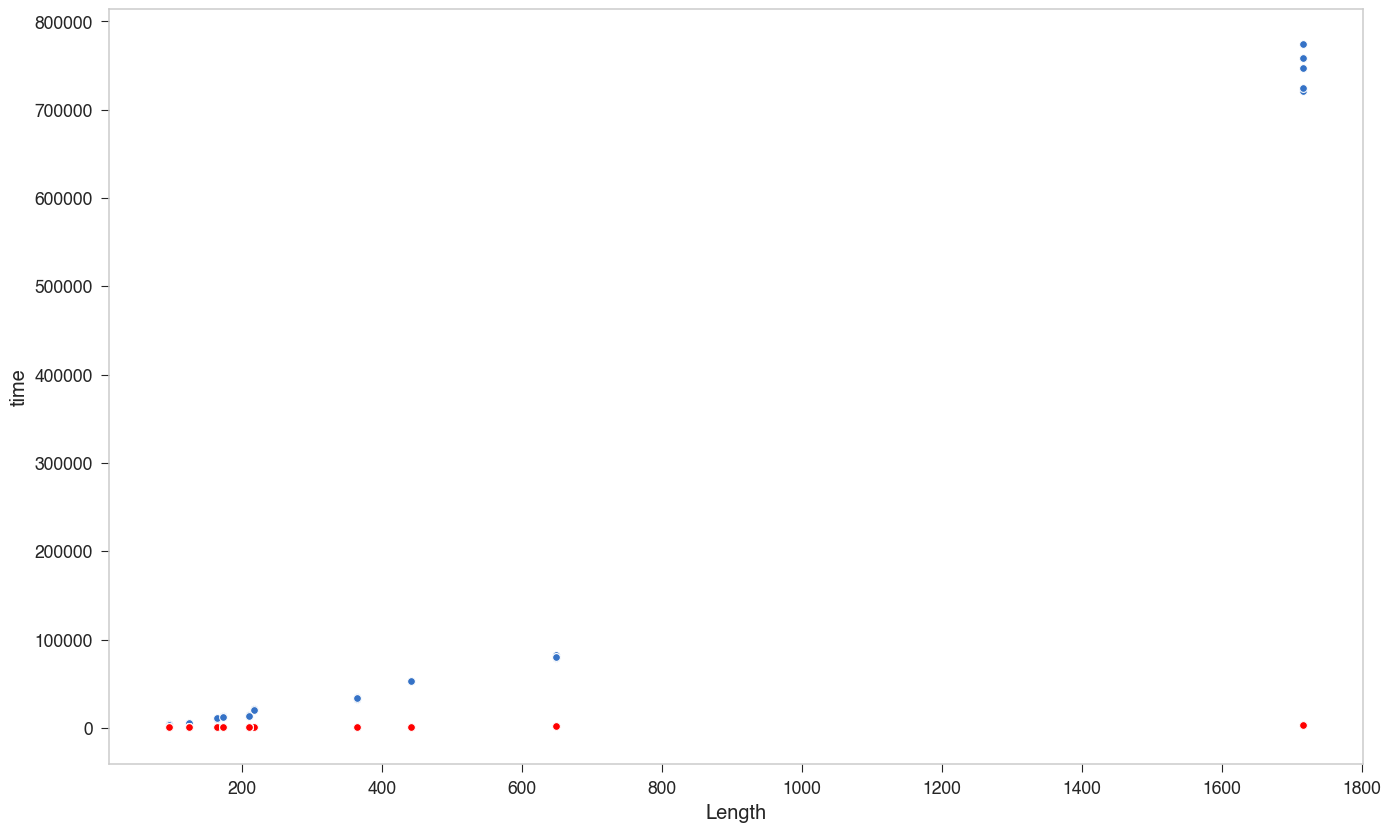

In [165]:
sns.scatterplot("Length", "Average", data=d2)
sns.scatterplot("Length", "time", data=info, color="red")
# plt.yscale("log")

In [170]:
pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "fmt", "6n7n", "2is1"]
pre = "/Users/weilu/Research/server/nov_2019/benchmark/20191025_benchmark"
info = []
for pdb in pdb_list:
    for i in range(5):
        fileLocation = f"run2/{pdb}/{i}/time.dat"
        try:
            t = float(np.loadtxt(f"{pre}/{fileLocation}"))
            info.append([pdb, i, t])
        except:
            print("skip ", fileLocation)
info = pd.DataFrame(info, columns=["Name", "Run", "time"])

In [171]:
pdb_length = {}
for pdb, length in zip(d["PDB id"], d["Length"]):
    pdb_length[pdb] = length
pdb_length["pex22"] = pdb_length["pex"]
info["Length"] = info["Name"].apply(lambda x: pdb_length[x])

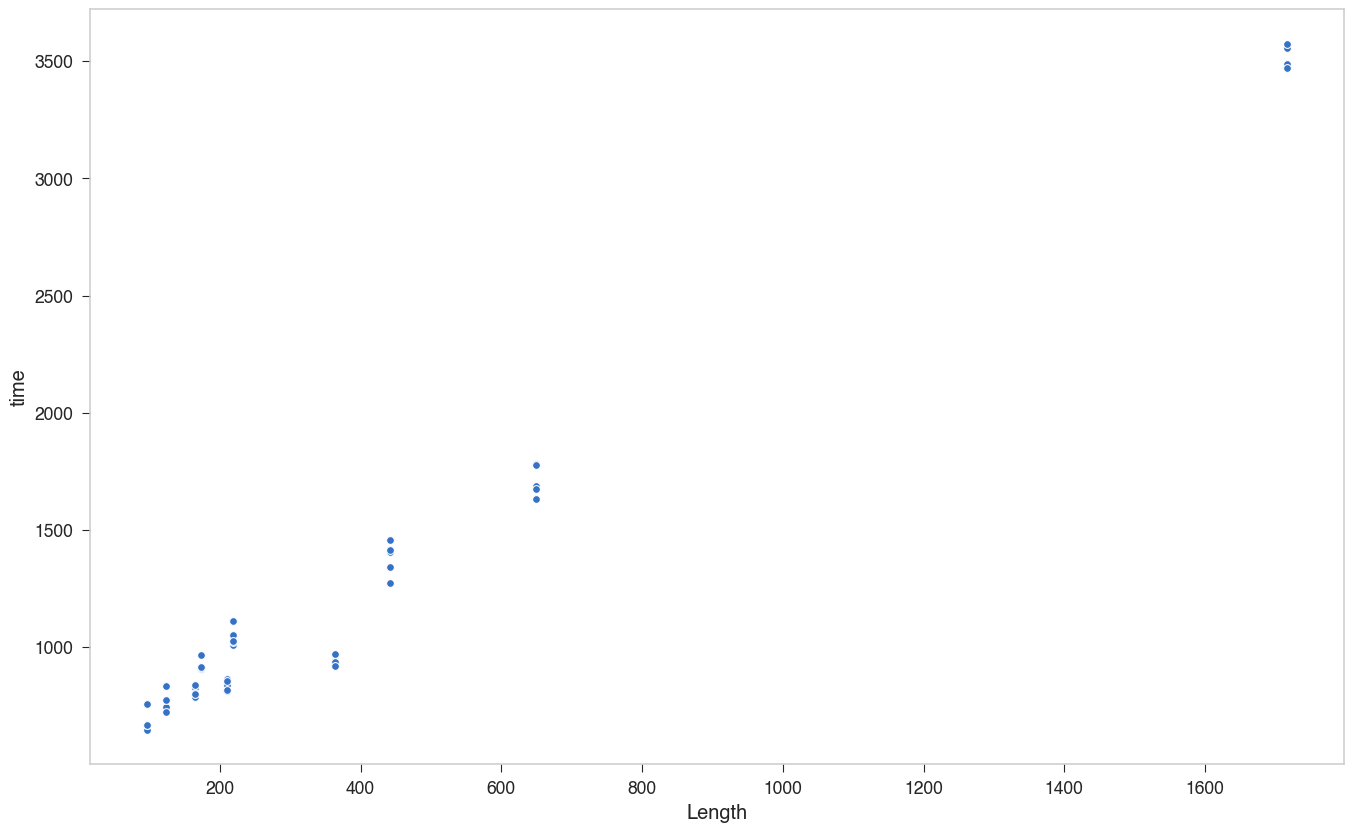

In [26]:
pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2"]
pre = "/Users/weilu/Research/server/nov_2019/benchmark/20191025_benchmark"
info = []
for pdb in pdb_list:
    for i in range(3):
        fileLocation = f"run1/{pdb}/{i}/time.dat"
        try:
            t = float(np.loadtxt(f"{pre}/{fileLocation}"))
            info.append([pdb, i, t])
        except:
            print("skip ", fileLocation)
info = pd.DataFrame(info, columns=["Name", "run", "time"])

skip  run1/6g57/0/time.dat
skip  run1/6q64/0/time.dat
skip  run1/6q64/1/time.dat
skip  run1/6q64/2/time.dat
skip  run1/pex22/0/time.dat
skip  run1/sos/0/time.dat


In [32]:
9040/3600

2.511111111111111

In [33]:
3600*4

14400

In [ ]:
d3.merge(info, )

In [74]:
d4 = d3.groupby("PDB id")["Time"].mean()

In [75]:
d4

PDB id
1tt8    10695.410
6btc     3736.860
6g57     5593.955
pex     12787.245
sos     20695.390
unk2    13801.120
Name: Time, dtype: float64

In [81]:
d5 = info.groupby("Name")["time"].mean()/10

In [77]:
d4

PDB id
1tt8    10695.410
6btc     3736.860
6g57     5593.955
pex     12787.245
sos     20695.390
unk2    13801.120
Name: Time, dtype: float64

In [82]:
d5

Name
1tt8      890.437981
6btc      689.062698
6g57      773.746623
pex22     980.672154
sos      1098.792778
unk2      905.051860
Name: time, dtype: float64

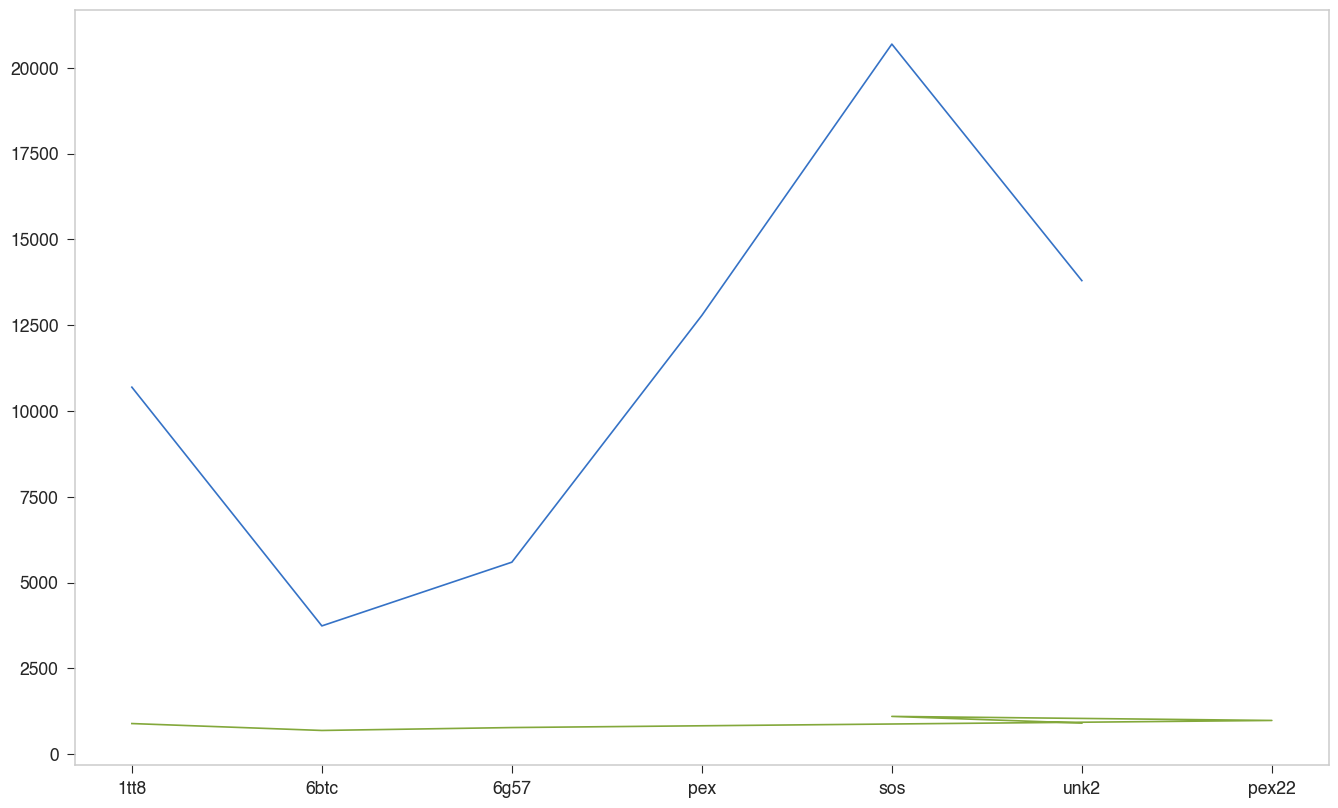

In [83]:
plt.plot(d4)
plt.plot(d5)

In [87]:
fastaFile = "/Users/weilu/Research/examples/openMM_simulation/1r69.fasta"
with open(fastaFile) as input_data:
    seq = ""
    for line in input_data:
        if(line[0] == ">"):
            print(line)
        elif(line == "\n"):
            pass
        else:
            seq += line.strip("\n")
print(seq)

charge_list = []
for i, res in enumerate(seq):
    if res == "R" or res == "K":
        charge_list.append([i, 1.0])
    elif res == "D" or res == "E":
        charge_list.append([i, -1.0])
    else:
        charge_list.append([i, 0.0])

saveTo = "/Users/weilu/Research/examples/openMM_simulation/1r69.charge"
np.savetxt(saveTo, charge_list, fmt='%i %.1f')

>CRYSTAL_STRUCTURE:A

SISSRVKSKRIQLGLNQAELAQKVGTTQQSIEQLENGKTKRPRFLPELASALGVSVDWLLNGT


In [114]:
a = np.loadtxt(saveTo, dtype=[('index', int), ('charge', float)])

In [116]:
a[0][0]

0

In [106]:
a[0][0] == 0

True

In [107]:
a[a[0][0]]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [118]:
parser = PDBParser()
structure = parser.get_structure("X", "/Users/weilu/Research/server/nov_2019/beta_pap_term_energy/simulation/native/crystal_structure.pdb")

/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3049.
  PDBConstructionWarning)
/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3206.
  PDBConstructionWarning)
/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 3382.
  PDBConstructionWarning)


In [ ]:
structure

In [266]:
fixer = PDBFixer(pdbid="6d3r")
fixer.findMissingResidues()
keys = fixer.missingResidues.keys()
print(keys)

dict_keys([])


In [276]:
fixer.missingResidues = {(0, 708): 20*['MET', 'ALA', 'ALA', 'PHE', 'LYS', 'PRO', 'ASN']}

In [277]:
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(keepWater=False)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(7.0)

In [268]:
keys = fixer.missingResidues.keys()
print(keys)

dict_keys([(0, 0)])


In [278]:
PDBFile.writeFile(fixer.topology, fixer.positions, open(os.path.join("/Users/weilu/Research/server/nov_2019/benchmark/", "test.pdb"), 'w'))

In [263]:
fixer = PDBFixer(pdbid="6jdq")
fixer.findMissingResidues()
keys = fixer.missingResidues.keys()
print(keys)

dict_keys([(0, 0), (0, 136), (0, 443), (0, 1069), (1, 0), (1, 97), (1, 117)])


In [264]:
fixer.missingResidues

{(0, 0): ['MET', 'ALA', 'ALA', 'PHE', 'LYS', 'PRO', 'ASN'],
 (0, 136): ['ARG', 'LYS'],
 (0, 443): ['TYR', 'GLY', 'LYS', 'LYS', 'ASN'],
 (0, 1069): ['GLU', 'HIS', 'HIS', 'HIS', 'HIS', 'HIS', 'HIS', 'HIS', 'HIS'],
 (1, 0): ['G',
  'G',
  'U',
  'C',
  'A',
  'C',
  'U',
  'C',
  'U',
  'G',
  'C',
  'U',
  'A',
  'U'],
 (1, 97): ['C', 'U'],
 (1, 117): ['U', 'C']}

In [ ]:
x = np.arange(10)
y = [0.5, 9.36, 52, 191, 350, 571.12, 912, 1207, 1682.69, 2135]
coefs = np.polynomial.polynomial.polyfit(x, y, 2)
ffit = np.polynomial.polynomial.Polynomial(coefs)
plt.scatter(x, y)
plt.scatter(x, ffit(x))